In [80]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm( vcenter=0)

import numpy as np
import sys
import lightning as L

sys.path.append('/users/local/c23lacro/script/NO_Sentinel/')
sys.path.append('/users/local/c23lacro/script/Koopman_DeepOperatorNet/')
from Lmodel import LKoopman
from light.Lmodel import NO_model

device = torch.device('cpu')

In [81]:
def total_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2)).detach().cpu().numpy()
    return RMSE

In [82]:
def spatial_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2, dim=(0, 1))).detach().cpu().numpy()
    return RMSE

In [83]:
def spatial_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2, dim=(0, 1))).detach().cpu().numpy()
    return RMSE

In [84]:
def temporal_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2, dim=(1, 2, 3))).detach().cpu().numpy()
    return RMSE

In [85]:
def channel_RMSE(out, data):
    
    maxs = torch.max(torch.max(torch.max(
        data, dim = (0)
        ).values, dim = (-1)).values, dim = (-1)).values
 
    RMSE  = torch.sqrt((torch.mean((out-data)**2, dim = (0,-2,-1 )))/maxs).detach().cpu().numpy()
    return RMSE

In [86]:
class KOOP(L.LightningModule):
    def __init__(self):
        super(KOOP, self).__init__()

CKPT_PATH_KOOP = '/users/local/c23lacro/script/Koopman_DeepOperatorNet/runs/27051013/1143/epoch=113-val_loss=0.00.ckpt'


In [87]:
##################################################################
#       Models
##################################################################

CKPT_PATH_KERNEL1 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_conv:FilterConvolution_kernel:[1, 1]_stride:1_skip:None_Res:False_activation:Linearlr:0.0001_batch:4/epoch=973-val_loss=0.00.ckpt'
CKPT_PATH_KERNEL3 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_conv:FilterConvolution_kernel:[3, 3]_stride:1_skip:None_Res:False_activation:Linearlr:0.0001_batch:4/epoch=973-val_loss=0.00.ckpt'
CKPT_PATH_FOU16 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_fourier_16_linear_Res:Truelr:0.0001batch:4/epoch=827-val_loss=0.00.ckpt'
CKPT_PATH_FOU32 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_fourier_32_linear_Res:True_lr:0.0001_batch:4/epoch=987-eval_loss_total=0.03.ckpt'
CKPT_PATH_WAV = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/wavelet_res_linearSkip_lr1em4/epoch=993-val_loss=0.00.ckpt'
CKPT_PATH_KOOP = '/users/local/c23lacro/script/Koopman_DeepOperatorNet/runs/27051013/1143/epoch=113-val_loss=0.00.ckpt'

model_kernel1 = NO_model.load_from_checkpoint(CKPT_PATH_KERNEL1).to(device)
model_kernel3 = NO_model.load_from_checkpoint(CKPT_PATH_KERNEL3).to(device)
model_fou16 = NO_model.load_from_checkpoint(CKPT_PATH_FOU16).to(device)
model_fou32 = NO_model.load_from_checkpoint(CKPT_PATH_FOU32).to(device)
model_wav = NO_model.load_from_checkpoint(CKPT_PATH_WAV).to(device)
model_koop = LKoopman.load_from_checkpoint(CKPT_PATH_KOOP).to(device)

model_kernel1.eval()
model_kernel3.eval()
model_fou16.eval()
model_fou32.eval()
model_wav.eval()
model_koop.eval()

print('')


No skip connection
No skip connection



In [116]:
##################################################################
#       Data
##################################################################

path_data = '/users/local/c23lacro/data/Fontainebleau_interpolated_subdomain64.npy'
sentinel_data = np.load(path_data)

if np.max(sentinel_data) > 1:
    sentinel_data /= np.max(sentinel_data)


sentinel_data_diff = sentinel_data[1:,...] - sentinel_data[:-1,...]

sentinel_data = torch.tensor(np.append( sentinel_data[1:,...],sentinel_data_diff, axis=1)).float()

In [117]:
koop_image0 = sentinel_data[240].permute(1,2,0).reshape(-1,20)
koop_image0.shape

torch.Size([4096, 20])

In [118]:
##################################################################
#       Prediction
##################################################################

i_image0 = 240

image0 = sentinel_data[i_image0].unsqueeze(0).to(device)

print('model_kernel1')
out_kernel1,_ = model_kernel1(image0,sentinel_data.shape[0]-i_image0)
out_kernel1 = out_kernel1.squeeze(0)

print('model_kernel3')
out_kernel3,_ = model_kernel3(image0,sentinel_data.shape[0]-i_image0)
out_kernel3 = out_kernel3.squeeze(0)

print('model_fou16')
out_fou16,_ = model_fou16(image0,sentinel_data.shape[0]-i_image0)
out_fou16 = out_fou16.squeeze(0)

print('model_fou32')
out_fou32,_ = model_fou32(image0,sentinel_data.shape[0]-i_image0)
out_fou32 = out_fou32.squeeze(0)

print('model_wav')
out_wav,_ = model_wav(image0,sentinel_data.shape[0]-i_image0)
out_wav = out_wav.squeeze(0)

print('model_koop')
out_koop,_ = model_koop(koop_image0,sentinel_data.shape[0]-i_image0)
out_koop = out_koop.squeeze(0)
out_koop = out_koop.reshape(64,64,-1,20).permute(2,3,0,1)

model_kernel1
model_kernel3
model_fou16
model_fou32
model_wav
model_koop


## Total RMSE

In [119]:
#make a table with the RMSE for each model
RMSE_dict = {}
RMSE_dict['kernel 1'] = total_RMSE(out_kernel1, sentinel_data[i_image0:])
RMSE_dict['kernel 3'] = total_RMSE(out_kernel3, sentinel_data[i_image0:])
RMSE_dict['fourier 16'] = total_RMSE(out_fou16, sentinel_data[i_image0:])
RMSE_dict['fourier 32'] = total_RMSE(out_fou32, sentinel_data[i_image0:])
RMSE_dict['wavelet'] = total_RMSE(out_wav, sentinel_data[i_image0:])
RMSE_dict['koopman'] = total_RMSE(out_koop, sentinel_data[i_image0:])


RMSEstd_dict = {}
RMSEstd_dict['kernel 1'] = np.var(temporal_RMSE(out_kernel1, sentinel_data[i_image0:]))
RMSEstd_dict['kernel 3'] = np.var(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 16'] = np.var(temporal_RMSE(out_fou16, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 32'] = np.var(temporal_RMSE(out_fou32, sentinel_data[i_image0:]))
RMSEstd_dict['wavelet'] = np.var(temporal_RMSE(out_wav, sentinel_data[i_image0:]))
RMSEstd_dict['koopman'] = np.var(temporal_RMSE(out_koop, sentinel_data[i_image0:]))

print('Model name  :  RMSE     +-  Variance')
print('-----------------------------------')
for key, value in RMSE_dict.items():
    num_spaces = 10 - len(key)
    print(key +" "*num_spaces, ' : ', "{:.5f}".format(value), ' +- ', "{:.7f}".format(RMSEstd_dict[key]))

Model name  :  RMSE     +-  Variance
-----------------------------------
kernel 1    :  0.02635  +-  0.0000464
kernel 3    :  0.02400  +-  0.0000577
fourier 16  :  0.04965  +-  0.0004262
fourier 32  :  0.02235  +-  0.0000593
wavelet     :  0.02340  +-  0.0000749
koopman     :  0.02093  +-  0.0000771


## Temporal RMSE

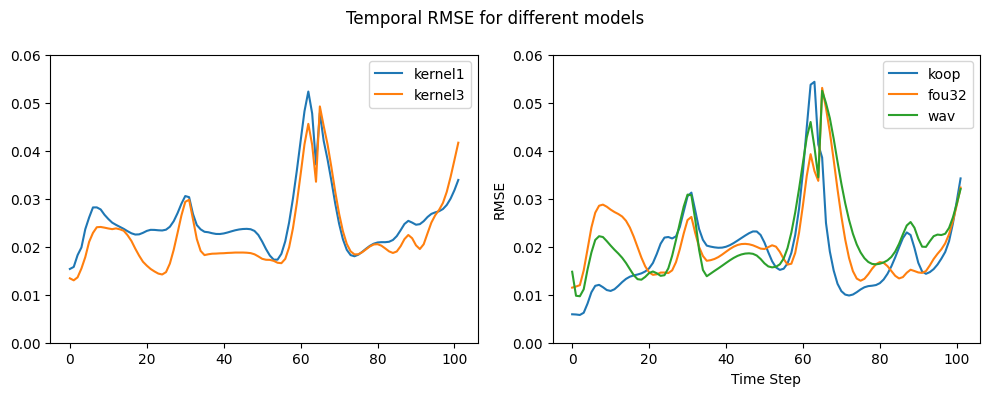

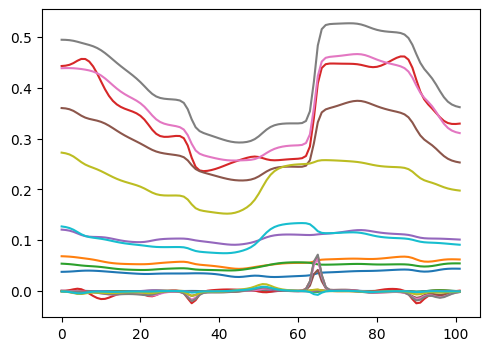

In [128]:
# Create a new figure
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Temporal RMSE for different models')
axs[0].set_ylim(0, 0.06)

# Create a subplot for the slice 0:340 with kernel1 and kernel3
axs[0].plot(temporal_RMSE(out_kernel1, sentinel_data[i_image0:]), label='kernel1')
axs[0].plot(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]), label='kernel3')
plt.xlabel('Time Step')
plt.ylabel('RMSE')
axs[0].legend()

# Create a subplot for the slice 0:160 with fou16, fou32 and wav
axs[1].plot(temporal_RMSE(out_koop, sentinel_data[i_image0:]), label='koop')
axs[1].plot(temporal_RMSE(out_fou32, sentinel_data[i_image0:]), label='fou32')
axs[1].plot(temporal_RMSE(out_wav, sentinel_data[i_image0:]), label='wav')
axs[1].set_ylim(0, 0.06)

plt.xlabel('Time Step')
plt.ylabel('RMSE')
axs[1].legend()

# Display the figure
plt.tight_layout()
plt.show()

plt.figure(figsize=(5.65, 4))
plt.plot(sentinel_data[i_image0:,:,32,32], label='sentinel')
plt.show()  

## Channel RMSE

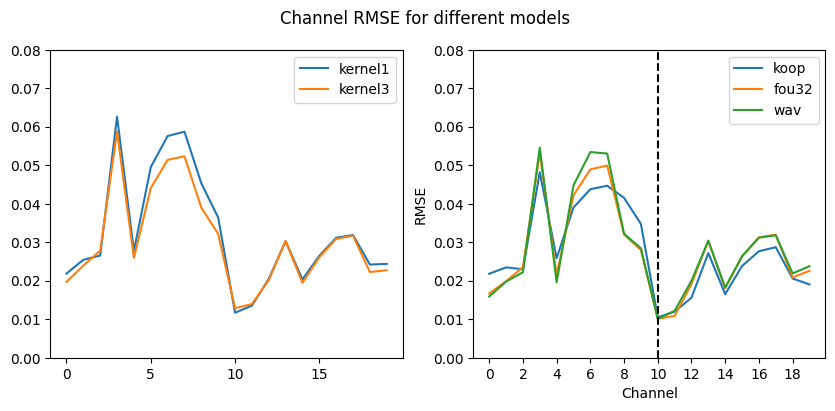

In [93]:
# Create a new figure
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Channel RMSE for different models')

# Create a subplot for the slice 0:340 with kernel1 and kernel3
axs[0].set_ylim(0, 0.08)

axs[0].plot(channel_RMSE(out_kernel1, sentinel_data[i_image0:]), label='kernel1')
axs[0].plot(channel_RMSE(out_kernel3, sentinel_data[i_image0:]), label='kernel3')
plt.xticks(np.arange(0, 20, 2))
# plt.axvline(x=10, color='black', linestyle='--')
plt.xlabel('Channel')
plt.ylabel('RMSE')
axs[0].legend()

# Create a subplot for the slice 0:160 with fou16, fou32 and wav
axs[1].plot(channel_RMSE(out_koop, sentinel_data[i_image0:]), label='koop')
axs[1].plot(channel_RMSE(out_fou32, sentinel_data[i_image0:]), label='fou32')
axs[1].plot(channel_RMSE(out_wav, sentinel_data[i_image0:]), label='wav')
plt.axvline(x=10, color='black', linestyle='--')
axs[1].set_ylim(0, 0.08)


plt.xticks(np.arange(0, 20, 2))
plt.xlabel('Channel')
plt.ylabel('RMSE')
axs[1].legend()

# Display the figure
# plt.tight_layout()
plt.show()

## Spatial RMSE

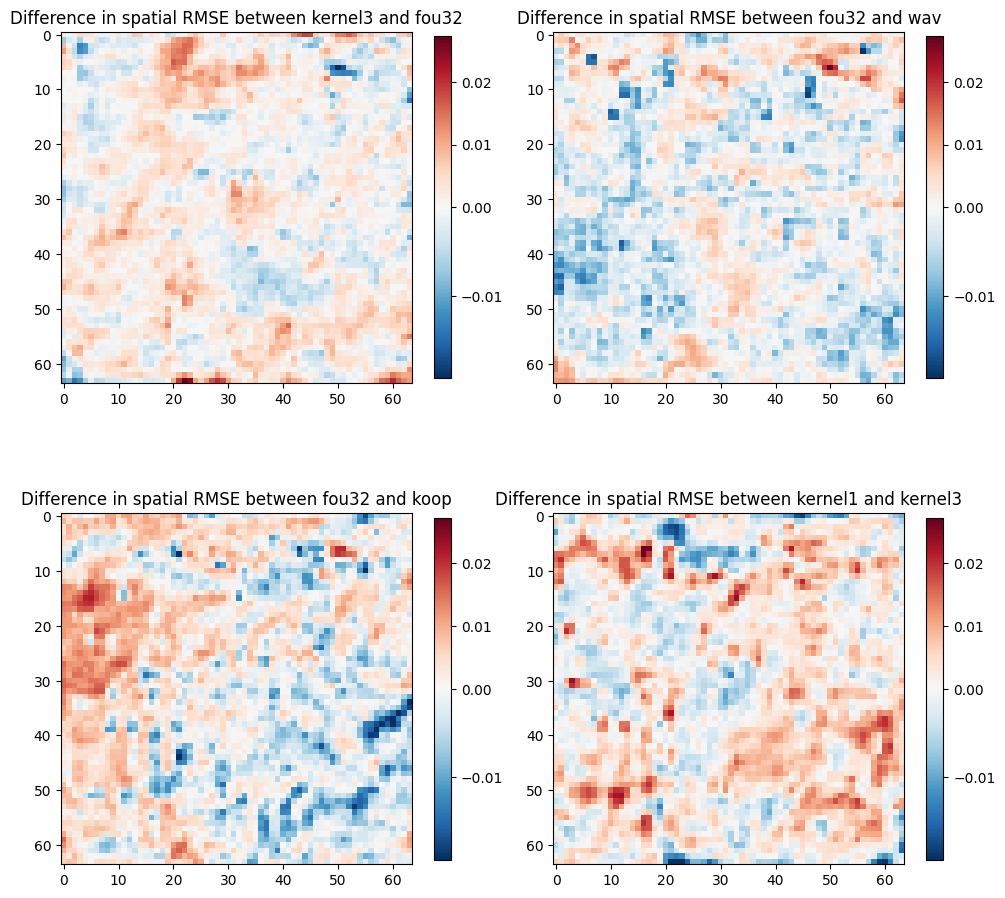

In [94]:
# Create a new figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Create a subplot for the difference between kernel3 and fou32
im1 = axs[0, 0].imshow(spatial_RMSE(out_kernel3, sentinel_data[i_image0:]) - 
                       spatial_RMSE(out_fou32, sentinel_data[i_image0:]), cmap='RdBu_r', norm=norm)
fig.colorbar(im1, ax=axs[0, 0], shrink=0.7)
axs[0, 0].set_title('Difference in spatial RMSE between kernel3 and fou32')

# Create a subplot for the difference between fou32 and wav
im2 = axs[0, 1].imshow(spatial_RMSE(out_fou32, sentinel_data[i_image0:]) - 
                       spatial_RMSE(out_wav, sentinel_data[i_image0:]), cmap='RdBu_r', norm=norm)
fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)
axs[0, 1].set_title('Difference in spatial RMSE between fou32 and wav')

# Create a subplot for the difference between fou32 and koop
data = spatial_RMSE(out_fou32, sentinel_data[i_image0:]) - spatial_RMSE(out_koop, sentinel_data[i_image0:])
im3 = axs[1, 0].imshow(data, cmap='RdBu_r', norm=norm)
fig.colorbar(im3, ax=axs[1, 0], shrink=0.7)
axs[1, 0].set_title('Difference in spatial RMSE between fou32 and koop')

# Create a subplot for the difference between kernel1 and kernel3
im4 = axs[1, 1].imshow(spatial_RMSE(out_kernel1, sentinel_data[i_image0:]) - 
                       spatial_RMSE(out_kernel3, sentinel_data[i_image0:]), cmap='RdBu_r', norm=norm)
fig.colorbar(im4, ax=axs[1, 1], orientation='vertical', shrink=0.7)
axs[1, 1].set_title('Difference in spatial RMSE between kernel1 and kernel3')

# Display the figure
plt.tight_layout()
plt.show()

# Noisy data

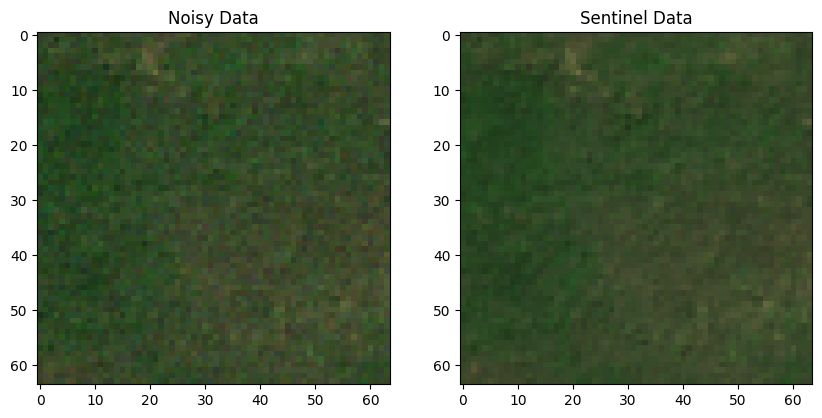

In [95]:
#add a gaussian noise to the first image of data

noise = torch.randn_like(sentinel_data[i_image0])*0.005
noisy_data = sentinel_data[i_image0] + noise

# Create a new figure
plt.figure(figsize=(10, 5))

# Create a subplot for the noisy data
plt.subplot(1, 2, 1)
plt.imshow((noisy_data)[[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)
plt.title('Noisy Data')

# Create a subplot for the sentinel data
plt.subplot(1, 2, 2)
plt.imshow(sentinel_data[i_image0,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)
plt.title('Sentinel Data')

# Display the figure
plt.show()

koop_image0 = noisy_data.permute(1,2,0).reshape(-1,20)


In [96]:
##################################################################
#       Prediction
##################################################################

image0 = noisy_data.unsqueeze(0).to(device)

print('model_kernel1')
out_kernel1,_ = model_kernel1(image0,sentinel_data.shape[0]-i_image0)
out_kernel1 = out_kernel1.squeeze(0)

print('model_kernel3')
out_kernel3,_ = model_kernel3(image0,sentinel_data.shape[0]-i_image0)
out_kernel3 = out_kernel3.squeeze(0)

print('model_fou16')
out_fou16,_ = model_fou16(image0,sentinel_data.shape[0]-i_image0)
out_fou16 = out_fou16.squeeze(0)

print('model_fou32')
out_fou32,_ = model_fou32(image0,sentinel_data.shape[0]-i_image0)
out_fou32 = out_fou32.squeeze(0)

print('model_wav')
out_wav,_ = model_wav(image0,sentinel_data.shape[0]-i_image0)
out_wav = out_wav.squeeze(0)

print('model_koop')
out_koop,_ = model_koop(koop_image0,sentinel_data.shape[0]-i_image0)
out_koop = out_koop.squeeze(0)
out_koop = out_koop.reshape(64,64,-1,20).permute(2,3,0,1)

model_kernel1
model_kernel3
model_fou16
model_fou32
model_wav
model_koop


## Total RMSE

In [97]:
#make a table with the RMSE for each model
RMSE_dict = {}
RMSE_dict['kernel 1'] = total_RMSE(out_kernel1, sentinel_data[i_image0:])
RMSE_dict['kernel 3'] = total_RMSE(out_kernel3, sentinel_data[i_image0:])
RMSE_dict['fourier 16'] = total_RMSE(out_fou16, sentinel_data[i_image0:])
RMSE_dict['fourier 32'] = total_RMSE(out_fou32, sentinel_data[i_image0:])
RMSE_dict['wavelet'] = total_RMSE(out_wav, sentinel_data[i_image0:])
RMSE_dict['koopman'] = total_RMSE(out_koop, sentinel_data[i_image0:])


RMSEstd_dict = {}
RMSEstd_dict['kernel 1'] = np.var(temporal_RMSE(out_kernel1, sentinel_data[i_image0:]))
RMSEstd_dict['kernel 3'] = np.var(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 16'] = np.var(temporal_RMSE(out_fou16, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 32'] = np.var(temporal_RMSE(out_fou32, sentinel_data[i_image0:]))
RMSEstd_dict['wavelet'] = np.var(temporal_RMSE(out_wav, sentinel_data[i_image0:]))
RMSEstd_dict['koopman'] = np.var(temporal_RMSE(out_koop, sentinel_data[i_image0:]))

print('Model name  :  RMSE     +-  Variance')
print('-----------------------------------')
for key, value in RMSE_dict.items():
    num_spaces = 10 - len(key)
    print(key +" "*num_spaces, ' : ', "{:.5f}".format(value), ' +- ', "{:.7f}".format(RMSEstd_dict[key]))

Model name  :  RMSE     +-  Variance
-----------------------------------
kernel 1    :  0.03296  +-  0.0000403
kernel 3    :  0.02423  +-  0.0000574
fourier 16  :  0.05016  +-  0.0004126
fourier 32  :  0.02385  +-  0.0000526
wavelet     :  4.04081  +-  14.5366716
koopman     :  0.03667  +-  0.0001747


## Temporal RMSE

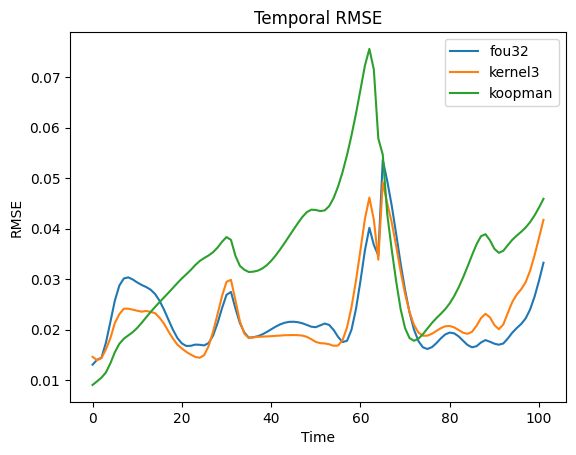

In [98]:
plt.plot(temporal_RMSE(out_fou32, sentinel_data[i_image0:]), label='fou32')
plt.plot(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]), label='kernel3')
plt.plot(temporal_RMSE(out_koop, sentinel_data[i_image0:]), label='koopman')
# plt.plot(temporal_RMSE(noisy_data.unsqueeze(0), sentinel_data[i_image0:]), label='persistance')
plt.title('Temporal RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.legend()

## Spatial RMSE

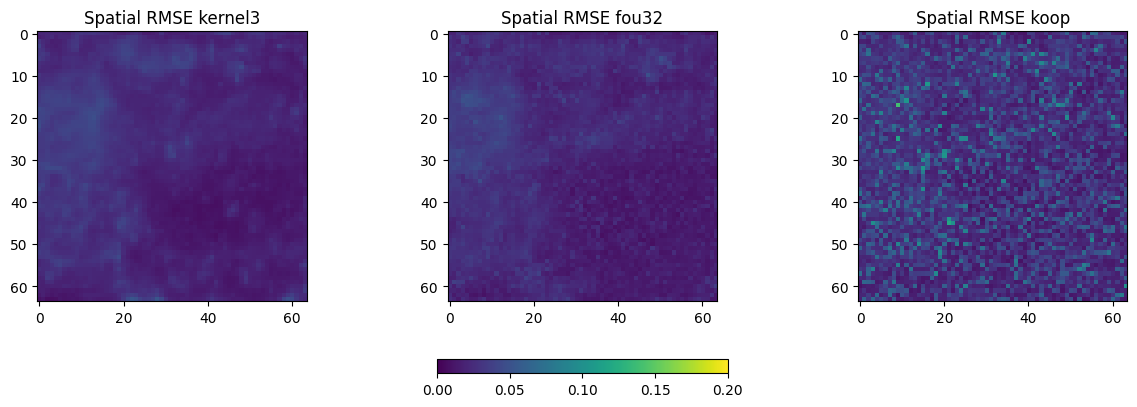

In [99]:
# Create a new figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colorbar limits
vmin = 0
vmax = 0.2

# Create a subplot for the out_kernel3 data
im1 = axs[0].imshow(spatial_RMSE(out_kernel3, sentinel_data[i_image0:]), vmin=vmin, vmax=vmax)
axs[0].set_title('Spatial RMSE kernel3')

# Create a subplot for the out_fou32 data
im2 = axs[1].imshow(spatial_RMSE(out_fou32, sentinel_data[i_image0:]), vmin=vmin, vmax=vmax)
axs[1].set_title('Spatial RMSE fou32')

# Create a subplot for the out_koop data
im3 = axs[2].imshow(spatial_RMSE(out_koop, sentinel_data[i_image0:]), vmin=vmin, vmax=vmax)
axs[2].set_title('Spatial RMSE koop')

# Add a global colorbar
fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='horizontal', shrink = 0.25)

# Display the figure
plt.show()

## Missing data

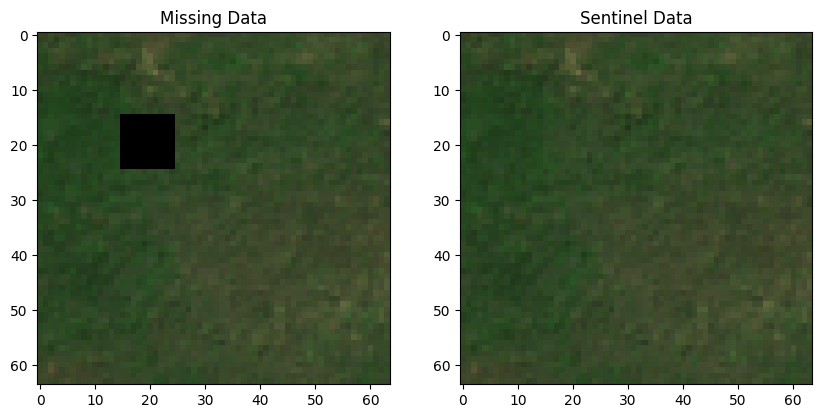

In [100]:
#random circle mask
mask = torch.ones(64,64)
mask[20 - 5:20 + 5, 20 - 5:20 + 5] = 0

i_image0 = 240
image0 = sentinel_data[i_image0].unsqueeze(0).to(device)
image0 = image0*(mask.unsqueeze(0).unsqueeze(0))

koop_image0 = image0.squeeze().permute(1,2,0).reshape(-1,20)

# Create a new figure
plt.figure(figsize=(10, 5))

# Create a subplot for the noisy data
plt.subplot(1, 2, 1)
plt.imshow(image0[0,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)
plt.title('Missing Data')

# Create a subplot for the sentinel data
plt.subplot(1, 2, 2)
plt.imshow(sentinel_data[240,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)
plt.title('Sentinel Data')

# Display the figure
plt.show()


In [101]:
##################################################################
#       Prediction
##################################################################


print('model_kernel1')
out_kernel1,_ = model_kernel1(image0,sentinel_data.shape[0]-i_image0)
out_kernel1 = out_kernel1.squeeze(0)

print('model_kernel3')
out_kernel3,_ = model_kernel3(image0,sentinel_data.shape[0]-i_image0)
out_kernel3 = out_kernel3.squeeze(0)

print('model_fou16')
out_fou16,_ = model_fou16(image0,sentinel_data.shape[0]-i_image0)
out_fou16 = out_fou16.squeeze(0)

print('model_fou32')
out_fou32,_ = model_fou32(image0,sentinel_data.shape[0]-i_image0)
out_fou32 = out_fou32.squeeze(0)

print('model_wav')
out_wav,_ = model_wav(image0,sentinel_data.shape[0]-i_image0)
out_wav = out_wav.squeeze(0)

print('model_koop')
out_koop,_ = model_koop(koop_image0,sentinel_data.shape[0]-i_image0)
out_koop = out_koop.squeeze(0)
out_koop = out_koop.reshape(64,64,-1,20).permute(2,3,0,1)

model_kernel1
model_kernel3
model_fou16
model_fou32
model_wav
model_koop


## Total RMSE

In [102]:
#make a table with the RMSE for each model
RMSE_dict = {}
RMSE_dict['kernel 1'] = total_RMSE(out_kernel1, sentinel_data[i_image0:])
RMSE_dict['kernel 3'] = total_RMSE(out_kernel3, sentinel_data[i_image0:])
RMSE_dict['fourier 16'] = total_RMSE(out_fou16, sentinel_data[i_image0:])
RMSE_dict['fourier 32'] = total_RMSE(out_fou32, sentinel_data[i_image0:])
RMSE_dict['wavelet'] = total_RMSE(out_wav, sentinel_data[i_image0:])
RMSE_dict['koopman'] = total_RMSE(out_koop, sentinel_data[i_image0:])


RMSEstd_dict = {}
RMSEstd_dict['kernel 1'] = np.var(temporal_RMSE(out_kernel1, sentinel_data[i_image0:]))
RMSEstd_dict['kernel 3'] = np.var(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 16'] = np.var(temporal_RMSE(out_fou16, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 32'] = np.var(temporal_RMSE(out_fou32, sentinel_data[i_image0:]))
RMSEstd_dict['wavelet'] = np.var(temporal_RMSE(out_wav, sentinel_data[i_image0:]))
RMSEstd_dict['koopman'] = np.var(temporal_RMSE(out_koop, sentinel_data[i_image0:]))

print('Model name  :  RMSE     +-  Variance')
print('-----------------------------------')
for key, value in RMSE_dict.items():
    num_spaces = 10 - len(key)
    print(key +" "*num_spaces, ' : ', "{:.5f}".format(value), ' +- ', "{:.7f}".format(RMSEstd_dict[key]))

Model name  :  RMSE     +-  Variance
-----------------------------------
kernel 1    :  0.03353  +-  0.0000455
kernel 3    :  0.02985  +-  0.0000546
fourier 16  :  0.05349  +-  0.0003410
fourier 32  :  0.04056  +-  0.0001168
wavelet     :  14020.62695  +-  179437168.0000000
koopman     :  0.03040  +-  0.0000767


## Temporal RMSE

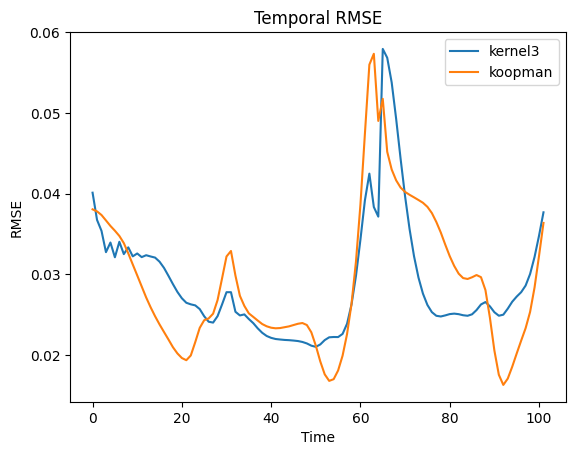

In [103]:
# plt.plot(temporal_RMSE(out_fou32, sentinel_data[i_image0:]), label='fou32')
plt.plot(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]), label='kernel3')
plt.plot(temporal_RMSE(out_koop, sentinel_data[i_image0:]), label='koopman')
# plt.plot(temporal_RMSE(noisy_data.unsqueeze(0), sentinel_data[i_image0:]), label='persistance')
plt.title('Temporal RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.legend()

## Spatial RMSE

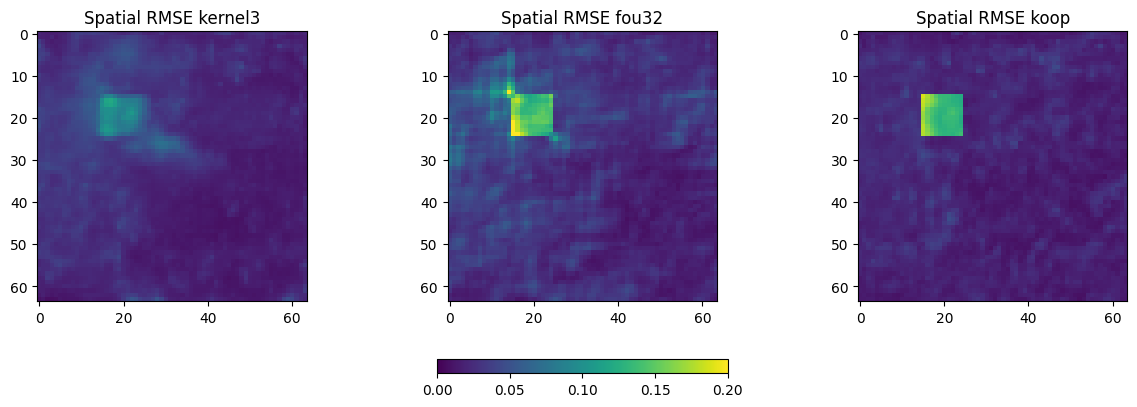

In [104]:
# Create a new figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colorbar limits
vmin = 0
vmax = 0.2

# Create a subplot for the out_kernel3 data
im1 = axs[0].imshow(spatial_RMSE(out_kernel3, sentinel_data[i_image0:]), vmin=vmin, vmax=vmax)
axs[0].set_title('Spatial RMSE kernel3')

# Create a subplot for the out_fou32 data
im2 = axs[1].imshow(spatial_RMSE(out_fou32, sentinel_data[i_image0:]), vmin=vmin, vmax=vmax)
axs[1].set_title('Spatial RMSE fou32')

# Create a subplot for the out_koop data
im3 = axs[2].imshow(spatial_RMSE(out_koop, sentinel_data[i_image0:]), vmin=vmin, vmax=vmax)
axs[2].set_title('Spatial RMSE koop')

# Add a global colorbar
fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='horizontal', shrink = 0.25)

# Display the figure
plt.show()

## "Super resolution with NO"

### from interpolate grid

In [105]:
sentinel_data_128_128 = torch.nn.functional.interpolate(sentinel_data, size=(128,128), mode='bilinear')
sentinel_data_128_128.shape
koop_image0 = sentinel_data_128_128[240].permute(1,2,0).reshape(-1,20)

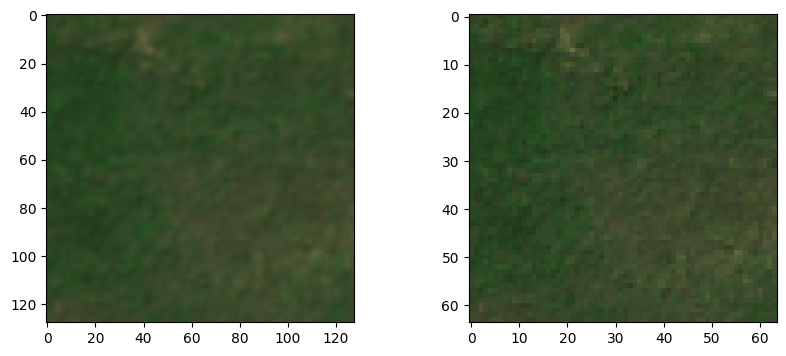

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Display the first image
axs[0].imshow(sentinel_data_128_128[240,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)

# Display the second image
axs[1].imshow(sentinel_data[240,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)

plt.show()


In [107]:
##################################################################
#       Prediction
##################################################################

i_image0 = 240

image0 = sentinel_data_128_128[i_image0].unsqueeze(0).to(device)

print('model_kernel1')
out_kernel1,_ = model_kernel1(image0,sentinel_data_128_128.shape[0]-i_image0)
out_kernel1 = out_kernel1.squeeze(0)

print('model_kernel3')
out_kernel3,_ = model_kernel3(image0,sentinel_data_128_128.shape[0]-i_image0)
out_kernel3 = out_kernel3.squeeze(0)

print('model_fou16')
out_fou16,_ = model_fou16(image0,sentinel_data_128_128.shape[0]-i_image0)
out_fou16 = out_fou16.squeeze(0)

print('model_fou32')
out_fou32,_ = model_fou32(image0,sentinel_data_128_128.shape[0]-i_image0)
out_fou32 = out_fou32.squeeze(0)

print('model_wav')
# out_wav,_ = model_wav(image0,sentinel_data_128_128.shape[0]-i_image0)
# out_wav = out_wav.squeeze(0)

print('model_koop')
out_koop,_ = model_koop(koop_image0,sentinel_data_128_128.shape[0]-i_image0)
out_koop = out_koop.squeeze(0)
out_koop = out_koop.reshape(128,128,-1,20).permute(2,3,0,1)

model_kernel1
model_kernel3
model_fou16
model_fou32
model_wav
model_koop


In [108]:
#make a table with the RMSE for each model
RMSE_dict = {}
RMSE_dict['kernel 1'] = total_RMSE(out_kernel1, sentinel_data_128_128[i_image0:])
RMSE_dict['kernel 3'] = total_RMSE(out_kernel3, sentinel_data_128_128[i_image0:])
RMSE_dict['fourier 16'] = total_RMSE(out_fou16, sentinel_data_128_128[i_image0:])
RMSE_dict['fourier 32'] = total_RMSE(out_fou32, sentinel_data_128_128[i_image0:])
# RMSE_dict['wavelet'] = total_RMSE(out_wav, sentinel_data_128_128[i_image0:])
RMSE_dict['koopman'] = total_RMSE(out_koop, sentinel_data_128_128[i_image0:])


RMSEstd_dict = {}
RMSEstd_dict['kernel 1'] = np.var(temporal_RMSE(out_kernel1, sentinel_data_128_128[i_image0:]))
RMSEstd_dict['kernel 3'] = np.var(temporal_RMSE(out_kernel3, sentinel_data_128_128[i_image0:]))
RMSEstd_dict['fourier 16'] = np.var(temporal_RMSE(out_fou16, sentinel_data_128_128[i_image0:]))
RMSEstd_dict['fourier 32'] = np.var(temporal_RMSE(out_fou32, sentinel_data_128_128[i_image0:]))
# RMSEstd_dict['wavelet'] = np.var(temporal_RMSE(out_wav, sentinel_data_128_128[i_image0:]))
RMSEstd_dict['koopman'] = np.var(temporal_RMSE(out_koop, sentinel_data_128_128[i_image0:]))

print('Model name  :  RMSE     +-  Variance')
print('-----------------------------------')
for key, value in RMSE_dict.items():
    num_spaces = 10 - len(key)
    print(key +" "*num_spaces, ' : ', "{:.5f}".format(value), ' +- ', "{:.7f}".format(RMSEstd_dict[key]))

Model name  :  RMSE     +-  Variance
-----------------------------------
kernel 1    :  0.02533  +-  0.0000496
kernel 3    :  0.02962  +-  0.0000623
fourier 16  :  0.04932  +-  0.0004315
fourier 32  :  0.02171  +-  0.0000612
koopman     :  0.02014  +-  0.0000763


### from missing data

In [109]:
sentinel_data_128_128.shape

torch.Size([342, 20, 128, 128])

In [110]:
sentinel_data_128_128_missing = sentinel_data_128_128.clone()
sentinel_data_128_128_missing[:,:,1::2,1::2] = 0
koop_image0 = sentinel_data_128_128_missing[240].permute(1,2,0).reshape(-1,20)

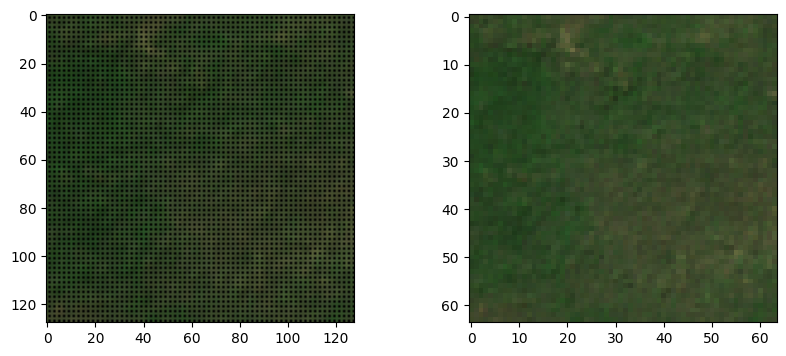

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Display the first image
axs[0].imshow(sentinel_data_128_128_missing[240,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)

# Display the second image
axs[1].imshow(sentinel_data[240,[2,1,0],:,:].permute(1,2,0).detach().cpu().numpy()*4)

plt.show()

In [112]:
##################################################################
#       Prediction
##################################################################

i_image0 = 240

image0 = sentinel_data_128_128_missing[i_image0].unsqueeze(0).to(device)

print('model_kernel1')
out_kernel1,_ = model_kernel1(image0,sentinel_data_128_128_missing.shape[0]-i_image0)
out_kernel1 = out_kernel1.squeeze(0)

print('model_kernel3')
out_kernel3,_ = model_kernel3(image0,sentinel_data_128_128_missing.shape[0]-i_image0)
out_kernel3 = out_kernel3.squeeze(0)

print('model_fou16')
out_fou16,_ = model_fou16(image0,sentinel_data_128_128_missing.shape[0]-i_image0)
out_fou16 = out_fou16.squeeze(0)

print('model_fou32')
out_fou32,_ = model_fou32(image0,sentinel_data_128_128_missing.shape[0]-i_image0)
out_fou32 = out_fou32.squeeze(0)

print('model_wav')
# out_wav,_ = model_wav(image0,sentinel_data_128_128.shape[0]-i_image0)
# out_wav = out_wav.squeeze(0)

print('model_koop')
out_koop,_ = model_koop(koop_image0,sentinel_data_128_128_missing.shape[0]-i_image0)
out_koop = out_koop.squeeze(0)
out_koop = out_koop.reshape(128,128,-1,20).permute(2,3,0,1)

model_kernel1
model_kernel3
model_fou16
model_fou32
model_wav
model_koop


In [113]:
#make a table with the RMSE for each model
RMSE_dict = {}
RMSE_dict['kernel 1'] = total_RMSE(out_kernel1[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2])
RMSE_dict['kernel 3'] = total_RMSE(out_kernel3[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2])
RMSE_dict['fourier 16'] = total_RMSE(out_fou16[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2])
RMSE_dict['fourier 32'] = total_RMSE(out_fou32[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2])
# RMSE_dict['wavelet'] = total_RMSE(out_wav, sentinel_data_128_128[i_image0:])
# RMSE_dict['koopman'] = total_RMSE(out_koop, sentinel_data_128_128[i_image0:])


RMSEstd_dict = {}
RMSEstd_dict['kernel 1'] = np.var(temporal_RMSE(out_kernel1[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2]))
RMSEstd_dict['kernel 3'] = np.var(temporal_RMSE(out_kernel3[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2]))
RMSEstd_dict['fourier 16'] = np.var(temporal_RMSE(out_fou16[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2]))
RMSEstd_dict['fourier 32'] = np.var(temporal_RMSE(out_fou32[:,:,0::2,0::2], sentinel_data_128_128[i_image0:][:,:,0::2,0::2]))
# RMSEstd_dict['wavelet'] = np.var(temporal_RMSE(out_wav, sentinel_data_128_128[i_image0:]))
# RMSEstd_dict['koopman'] = np.var(temporal_RMSE(out_koop, sentinel_data_128_128[i_image0:]))

print('Model name  :  RMSE     +-  Variance')
print('-----------------------------------')
for key, value in RMSE_dict.items():
    num_spaces = 10 - len(key)
    print(key +" "*num_spaces, ' : ', "{:.5f}".format(value), ' +- ', "{:.7f}".format(RMSEstd_dict[key]))

Model name  :  RMSE     +-  Variance
-----------------------------------
kernel 1    :  0.02539  +-  0.0000500
kernel 3    :  0.06196  +-  0.0007796
fourier 16  :  0.05025  +-  0.0003966
fourier 32  :  0.06813  +-  0.0009664
